# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Открытие файла с данными и изучение общей информации

Импортируем библиотеки и откроем файл с датасетом:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

Выведем первые пять строк датафрейма:

In [3]:
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Выведем основную информацию о датафрейме:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В некоторых столбцах есть пропуски данных, которые в дальнейшем будут обработаны. Построим гистограмму для всех числовых столбцов таблицы на одном графике:

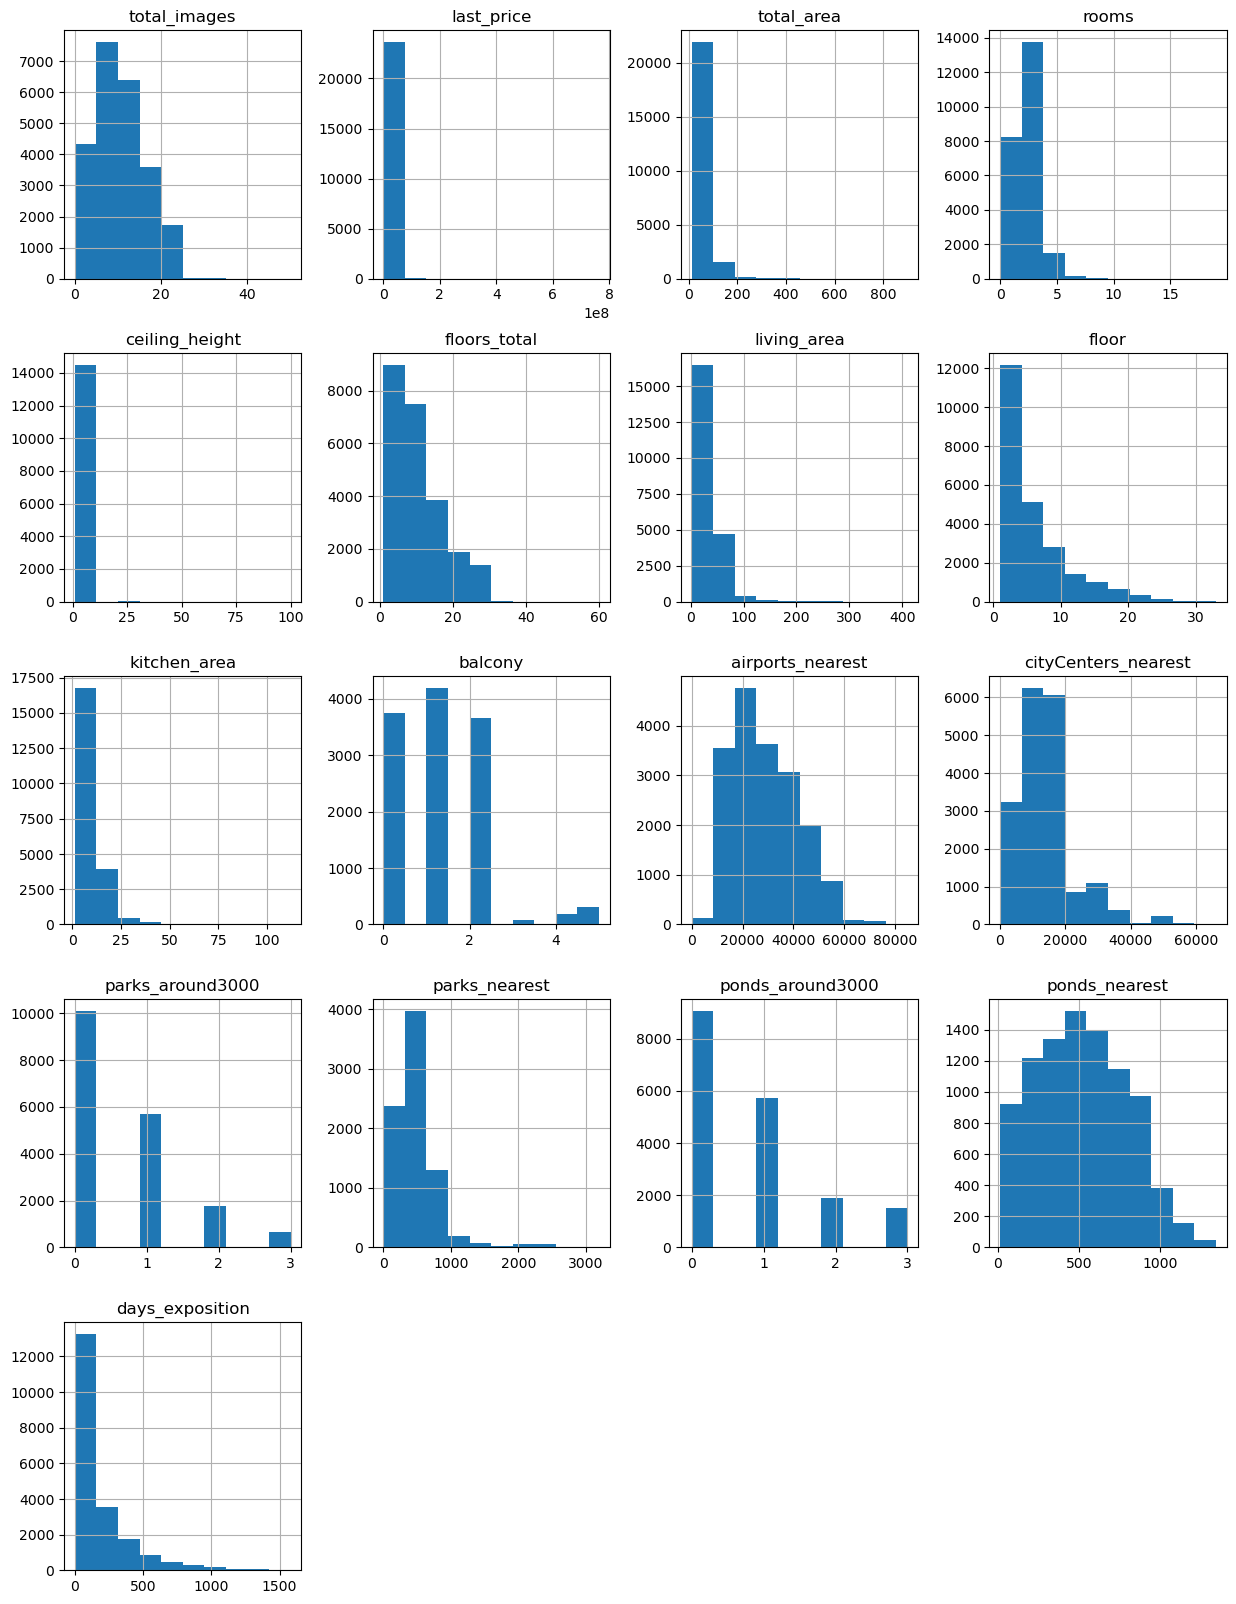

In [5]:
data.hist(figsize=(15, 20));

В части столбцах наблюдаются аномальные значения, которые необоходимо будет обработать для дальнейшего анализа данных.

### Предобработка данных

Подсчитаем пропуски в датафрейме:

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

В 14 столбцах обнаружены пропущенные данные. Пропуски в данных появляются разными путями. Например, пользователь не указал какие-нибудь сведения или автоматизированная система сбора информации дала сбой. Иногда пропуски оставляют умышленно, рассчитывая на автозаполнение спецсимволами. Таким образом, основными причинами пропусков являются человеческий фактор и техническая ошибка.

Попробуем заполнить пропущенные значения там, где это возможно:
1. Если продавец не указал число балконов, то, скорее всего, в его квартире их нет. Такие пропуски можно заменить на число 0.
2. Если не указана высота потолков, то ее можно заменить на медианное значение.
3. Пропуски в этажности здания можно заменить на 1, т.к. скорее всего это одноэтажный дом (такие есть в Москве и Санкт-Петербурге).
4. Пропущенные значения в определении апартаментов можно заменить на False, т.к. пропусков около 88% всех строк, и скорее всего это квартиры.
5. Пропущенные значения в числе парков в водоемов в радиусе 3 км можно заменить на 0, т.к. скорее всего поблизости этих квартир нет парков и водоемов.

In [7]:
data['balcony'] = data['balcony'].fillna(0)
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['floors_total'] = data['floors_total'].fillna(1)
data['is_apartment'] = data['is_apartment'].fillna(False)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

C:\Users\rgrishanin\AppData\Local\Temp\ipykernel_12560\1638875478.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_apartment'] = data['is_apartment'].fillna(False)


Оставшиеся пропущенные значения восстановить невозможно:

In [8]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

В текущем датафрейме имеются столбцы, в которых нужно изменить тип данных:
1. Число балконов, всего этажей в доме, число парков в радиусе 3 км, число водоемов в радиусе 3 км и общая площадь квартиры в квадратных метрах (м²) - меняем тип с float на int, т.к. в большинстве случает эти показатели характеризуются целыми числами, а не вещественными.
2. Признак апартаментов меняем на булев тип.
3. Дату публикации объявления приводим к формату datetime.

In [9]:
int_list = ['balcony', 'floors_total', 'parks_around3000', 'ponds_around3000', 'total_area']
for i in int_list:
    data[i] = data[i].astype('int')

data['is_apartment'] = data['is_apartment'].astype('bool')

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Проверяем изменение типов данных:

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  int32         
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int32         
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

В столбце с названиями населенных пунктов имеются неявные дубликаты. Например, "поселок Рябово" и "поселок городского типа Рябово", "поселок Тельмана" и "посёлок Тельмана" - это обозначения одних и тех же населенных пунктов. Избавимся от неявных дубликатов:
1. Заменим символы "ё" на "е".
2. Составим список населенных пунктов для замены.
3. Проведем замену наименований населенных пунктов в текущем столбце датафрейма.

In [11]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
replace_list = [
    [['поселок Мурино'], 'Мурино'],
    [['городской поселок Павлово', 'село Павлово', 'поселок городского типа Павлово'], 'Павлово'],
    [['поселок городского типа Рощино', 'городской поселок Рощино'], 'Рощино'],
    [['поселок Рябово', 'поселок городского типа Рябово'], 'Рябово'],
    [['городской поселок Большая Ижора', 'поселок городского типа Большая Ижора'], 'Большая Ижора'],
    [['поселок станции Вещево', 'поселок при железнодорожной станции Вещево'], 'Вещево'],
    [['деревня Гарболово', 'поселок Гарболово'], 'Гарболово'],
    [['поселок станции Громово', 'поселок Громово'], 'Громово'],
    [['поселок Зимитицы', 'деревня Зимитицы'], 'Зимитицы'],
    [['деревня Калитино', 'поселок Калитино'], 'Калитино'],
    [['деревня Кудрово'], 'Кудрово'],
    [['поселок Лесное', 'коттеджный поселок Лесное'], 'Лесное'],
    [['поселок городского типа Лесогорский', 'городской поселок Лесогорский'], 'Лесогорский'],
    [['поселок Любань'], 'Любань'],
    [['городской поселок Мга', 'поселок городского типа Мга'], 'Мга'],
    [['городской поселок Назия', 'поселок городского типа Назия'], 'Назия'],
    [['село Никольское'], 'Никольское'],
    [['поселок станции Приветнинское', 'поселок при железнодорожной станции Приветнинское'], 'Приветнинское'],
    [['поселок городского типа Приладожский', 'садовое товарищество Приладожский'], 'Приладожский'],
    [['деревня Рабитицы', 'поселок Рабитицы'], 'Рабитицы'],
    [['поселок городского типа Рахья', 'садовое товарищество Рахья'], 'Рахья'],
    [['поселок городского типа Советский', 'городской поселок Советский'], 'Советский'],
    [['деревня Федоровское', 'городской поселок Федоровское'], 'Федоровское'],
    [['поселок Щеглово', 'деревня Щеглово'], 'Щеглово']
]
for i in replace_list:
    data['locality_name'] = (data['locality_name'].replace(i[0], i[1], regex=True))

На этом предобработка данных выполнена.

### Добавление в таблицу новых столбцов

Для проведения дальнейшего исследования необходимо добавить в таблицу новые столбцы:

1. Цена одного квадратного метра:

In [12]:
data['total_area_price'] = (data['last_price'] / data['total_area']).round(2)

2. День недели публикации объявления (0 — понедельник, 1 — вторник и т.д.):

In [13]:
data['day_exposition'] = data['first_day_exposition'].dt.weekday

3. Месяц публикации объявления:

In [14]:
data['month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month

4. Год публикации объявления:

In [15]:
data['year_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year

5. Тип этажа квартиры (значения - "первый", "последний", "другой"):

In [16]:
def get_floor_text(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

def get_floor_ch(row):
    if row['floor'] == 1:
        return 1
    if row['floor'] == row['floors_total']:
        return 3
    return 2

data['floor_type_text'] = data.apply(get_floor_text, axis=1)
data['floor_type_ch'] = data.apply(get_floor_ch, axis=1)

6. Расстояние до центра города в километрах:

In [17]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(0)

### Проведение исследовательского анализа данных

#### Анализ данных, представленных в датафрейме

**1. Общая площадь**

Отобразим данные в виде гистограммы и числового описания выборки:

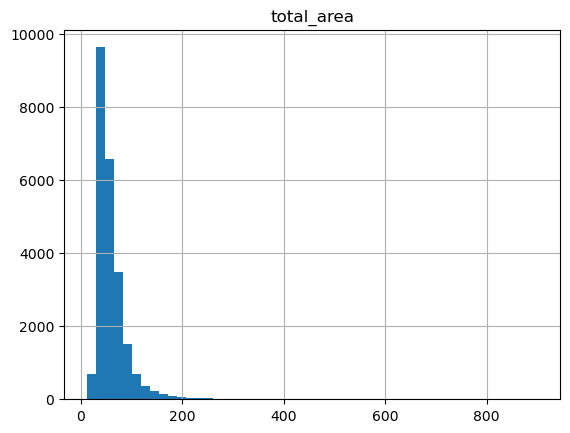

In [18]:
data.hist('total_area', bins=50);

In [19]:
data['total_area'].describe()

count    23699.000000
mean        60.120511
std         35.665822
min         12.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        900.000000
Name: total_area, dtype: float64

По представленным данным можно сделать вывод, данные по квартирам, имеющием площадь меньше 20 м² и выше 200 м², для данной выборки являются аномальными значениями, которые можно не учитывать в дальнейшем анализе. Построим гистограмму по выборке, из которой исключим аномальные значения:

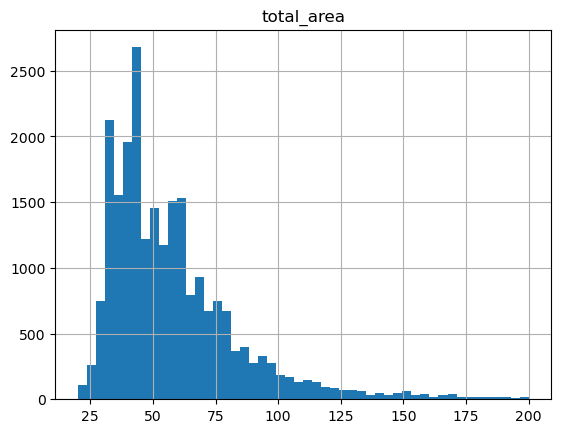

In [20]:
data.query('20 < = total_area <= 200').hist('total_area', bins=50);

In [21]:
data.query('20 <= total_area <= 200')['total_area'].describe()

count    23446.000000
mean        58.004692
std         26.534107
min         20.000000
25%         40.000000
50%         52.000000
75%         69.000000
max        200.000000
Name: total_area, dtype: float64

После исключения аномалий выборку можно использовать для дальнейшейго анализа. Как видно из представленных выше данных, наибольшее количество квартир в продаже - это небольшие студии и квартиры 30-75 м².

**2. Жилая площадь**

Отобразим данные в виде гистограммы и числового описания выборки:

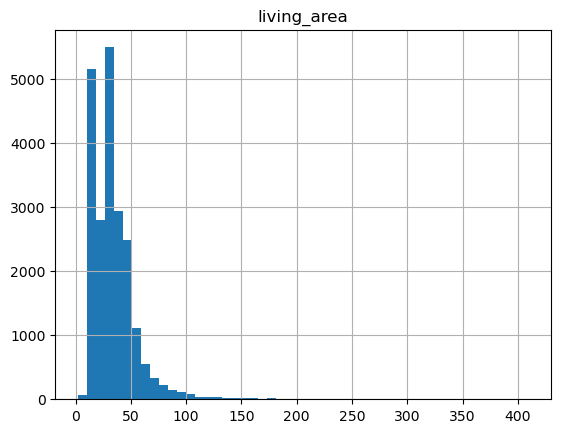

In [22]:
data.hist('living_area', bins=50);

In [23]:
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Здесь также видно, что данные по квартирам, имеющием жилую площадь меньше 2 м² и выше 100 м², можно не учитывать в дальнейшем анализе. Построим гистограмму по выборке, из которой исключим аномальные значения:

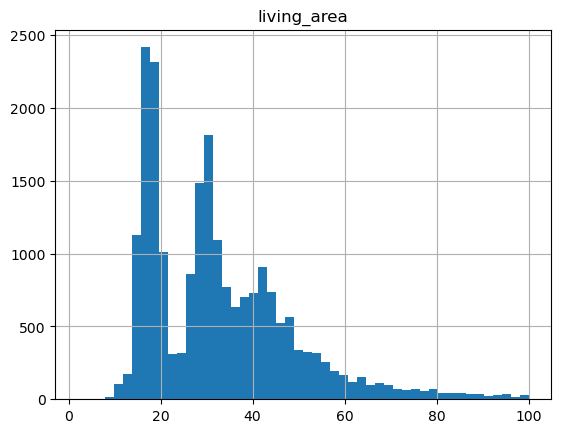

In [24]:
data.query('2 < = living_area <= 100').hist('living_area', bins=50);

In [25]:
data.query('2 <= living_area <= 100')['living_area'].describe()

count    21442.000000
mean        32.636450
std         15.823574
min          2.000000
25%         18.500000
50%         30.000000
75%         42.000000
max        100.000000
Name: living_area, dtype: float64

После исключения выбивающихся значений в выборке мы наблюдаем аномально низкое число квартир с жилой площадью от 20 до 25 м². Возможно, часть данных утеряна в связи с наличием в выборке 1903 пропусков данных.

**3. Площадь кухни**

Отобразим данные в виде гистограммы и числового описания выборки:

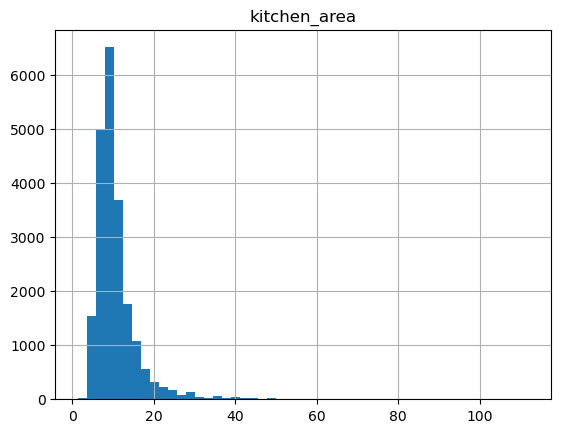

In [26]:
data.hist('kitchen_area', bins=50);

In [27]:
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

По представленным данным можно сделать вывод, данные по квартирам, имеющием площадь кухни меньше 4 м² и выше 30 м², для данной выборки являются аномальными значениями, которые можно не учитывать в дальнейшем анализе. Построим гистограмму по выборке, из которой исключим аномальные значения:

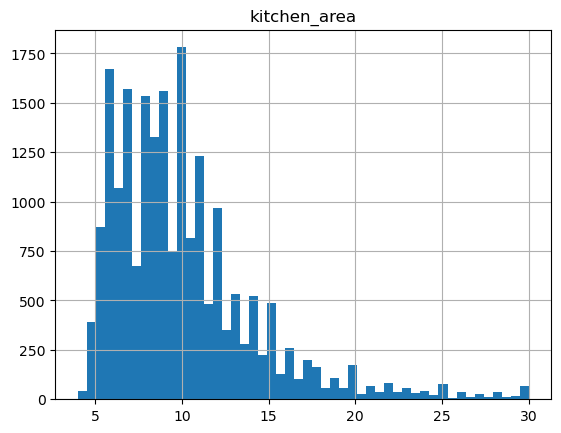

In [28]:
data.query('4 <= kitchen_area <= 30').hist('kitchen_area', bins=50);

In [29]:
data.query('4 <= kitchen_area <= 30')['kitchen_area'].describe()

count    21069.000000
mean        10.097729
std          4.190436
min          4.000000
25%          7.000000
50%          9.000000
75%         11.800000
max         30.000000
Name: kitchen_area, dtype: float64

После исключения аномалий в выборке мы наблюдаем достаточно резкую ступенчатую гистограмму. Возможно, часть данных утеряна в связи с наличием в выборке 2278 пропусков данных.

**4. Цена объекта**

Отобразим данные в виде гистограммы и числового описания выборки:

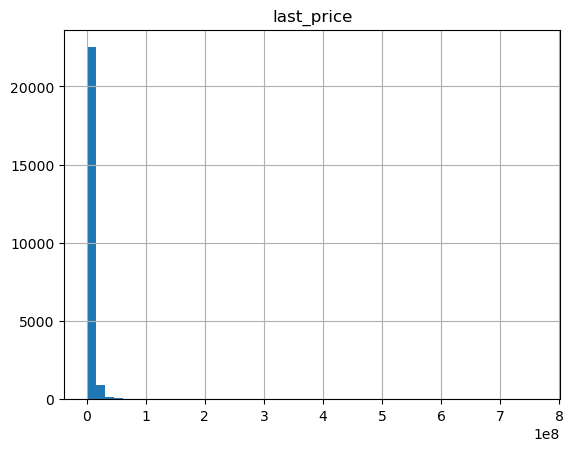

In [30]:
data.hist('last_price', bins=50);

In [31]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

В представленных данных также наблюдаются аномалии, где стоимость квартиры либо слишком низкая, любо слишком высокая. Построим гистограмму по выборке, из которой исключим аномальные значения:

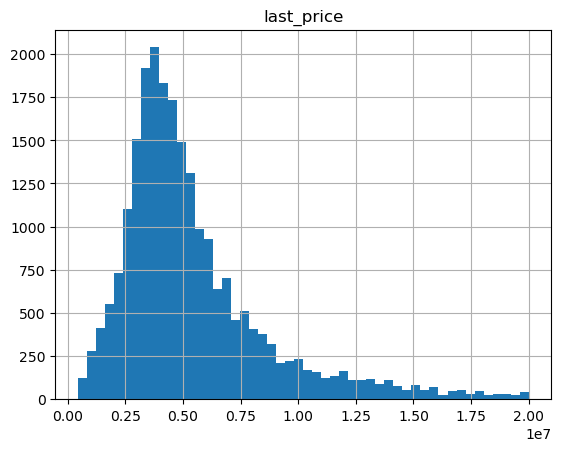

In [32]:
data.query('400000 <= last_price <= 20000000').hist('last_price', bins=50);

In [33]:
data.query('400000 <= last_price <= 20000000')['last_price'].describe()

count    2.299100e+04
mean     5.423842e+06
std      3.220033e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.550000e+06
75%      6.500000e+06
max      2.000000e+07
Name: last_price, dtype: float64

После исключения аномалий в выборке мы наблюдаем достаточно ровную гистограмму, с распределением, похожим на нормальное. Эти данные можно использовать для дальнейшего анализа.

**5. Количество комнат**

Отобразим данные в виде гистограммы и числового описания выборки:

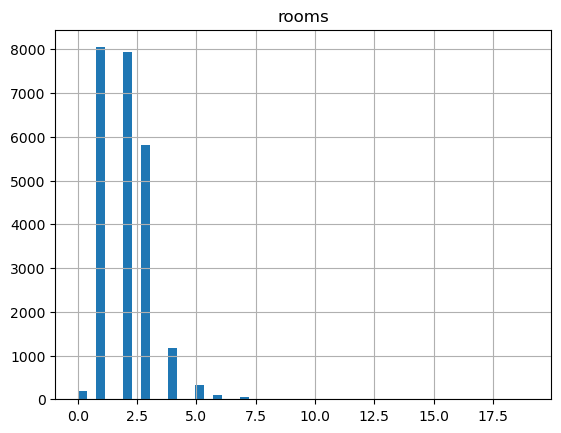

In [34]:
data.hist('rooms', bins=50);

In [35]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Квартиры с нулевым количеством комнат явно являются из ряда вон выходящим явлением, тут бесспорно какая-то ошибка в данных. Также квартиры с числом комнат выше 5 также можно отнести к явным аномалиям. Поэтому уберем такие квартиры из данных и построим гистограмму по полученной выборке:

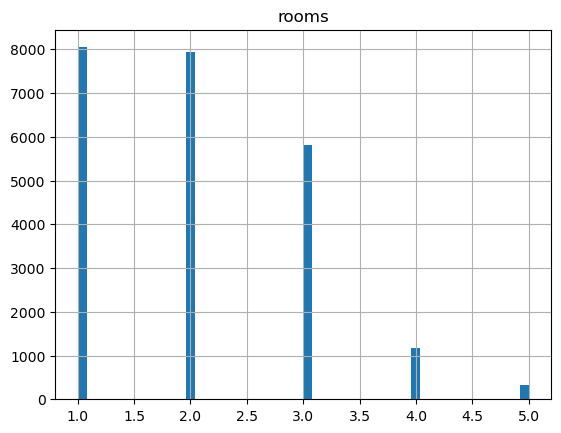

In [36]:
data.query('0 < rooms <= 5').hist('rooms', bins=50);

In [37]:
data.query('0 < rooms <= 5')['rooms'].describe()

count    23307.000000
mean         2.047411
std          0.959638
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

Исключив аномалии из выборки получили гистограмму в распределением, похожим на пуассоновское. Как видно из данных, большинство квартир в продаже - это одно- и двухкомнатные.

**6. Высота потолков**

Отобразим данные в виде гистограммы и числового описания выборки:

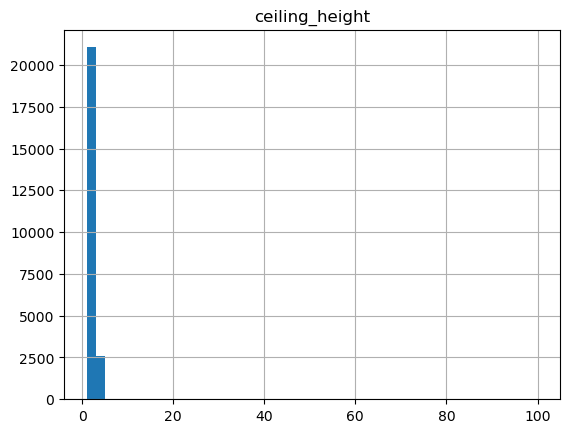

In [38]:
data.hist('ceiling_height', bins=50);

In [39]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

Обычная высота потолка в квартире составляет 2.5-3.5 метра. Согласно гистограмме, мы наблюдаем данные, где высота потолка ниже и выше обозначенного диапазона. Если в данных имеются квратиры с высотой потолка 25-35 метров, то логично предположить, что на самом деле это вещественные значения - 2.5-3.5 метра. Попробем обработать аномалии в этом столбце:

In [40]:
def ceiling_height_upd(ceiling_height):
    if 25 <= ceiling_height <= 35:
        return ceiling_height / 10
    return ceiling_height

data['ceiling_height_upd'] = data['ceiling_height'].apply(ceiling_height_upd)

Построим гистограмму по полученной выборке:

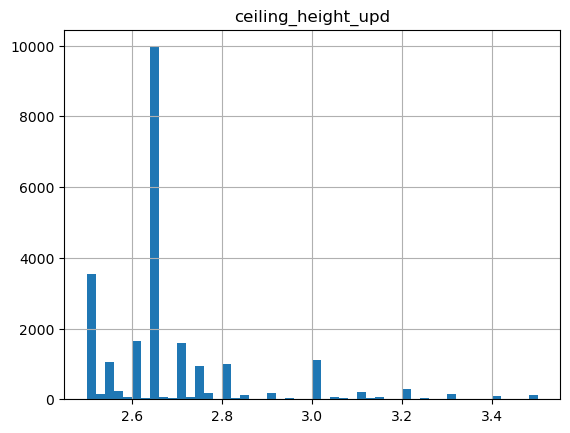

In [41]:
data.query('2.5 <= ceiling_height_upd <= 3.5').hist('ceiling_height_upd', bins=50);

In [42]:
data.query('2.5 <= ceiling_height_upd <= 3.5')['ceiling_height_upd'].describe()

count    23341.000000
mean         2.684059
std          0.175514
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          3.500000
Name: ceiling_height_upd, dtype: float64

По полученной выборке можно судить, что около половины всех продаваемых квартир имеют высоту потолка около 2.65 метра.

**7. Тип этажа квартиры**

Отобразим данные в виде столбчатой диаграммы:

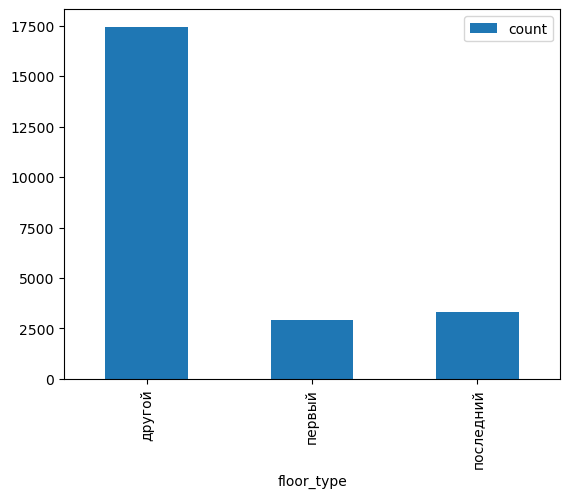

In [43]:
floor_type_pivot_table = data.pivot_table(index='floor_type_text', values='total_images', aggfunc=['count']).reset_index()
floor_type_pivot_table.columns = ['floor_type', 'count']
floor_type_pivot_table.plot(kind='bar', x='floor_type', y='count');

Большая часть продаваемых квартир ожидаемо находится на этажах между первым и последним, при этом квартир на последнем этаже чуть больше, чем квартир на первом.

**8. Общее количество этажей в доме**

Отобразим данные в виде гистограммы и числового описания выборки:

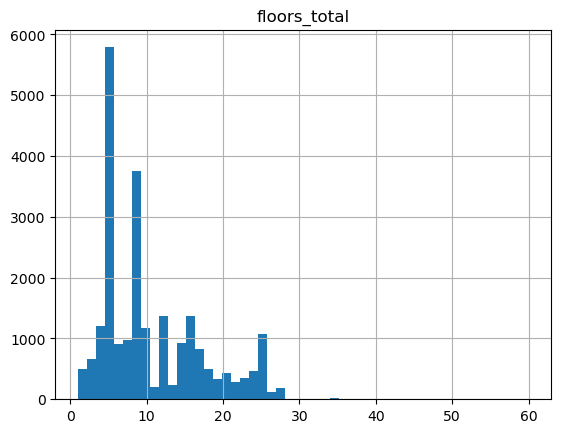

In [44]:
data.hist('floors_total', bins=50);

In [45]:
data['floors_total'].describe()

count    23699.000000
mean        10.638719
std          6.610834
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Дома, в которых 1 этаж или больше 27 этажей - нетипичные здания, что и показывает представленная выше гистограмма. Построим гистограмму по выборке без этих нетипичных значений:

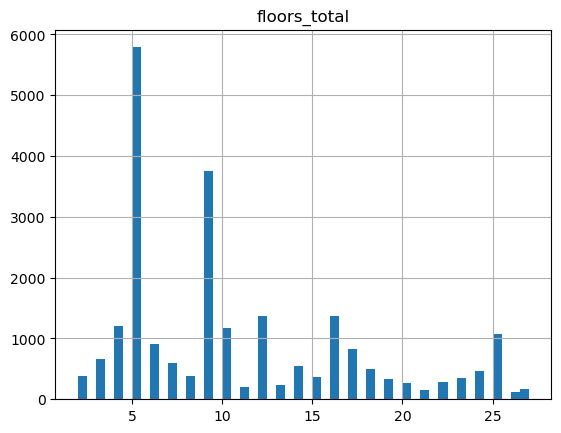

In [46]:
data.query('1 < floors_total <= 27').hist('floors_total', bins=50);

In [47]:
data.query('1 < floors_total <= 27')['floors_total'].describe()

count    23534.000000
mean        10.632914
std          6.507731
min          2.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         27.000000
Name: floors_total, dtype: float64

Из полученных данных можно сделать вывод, что большинство квартир продаются в пяти- и девятиэтажках.

**9. Расстояние до центра города в метрах**

Отобразим данные в виде гистограммы и числового описания выборки:

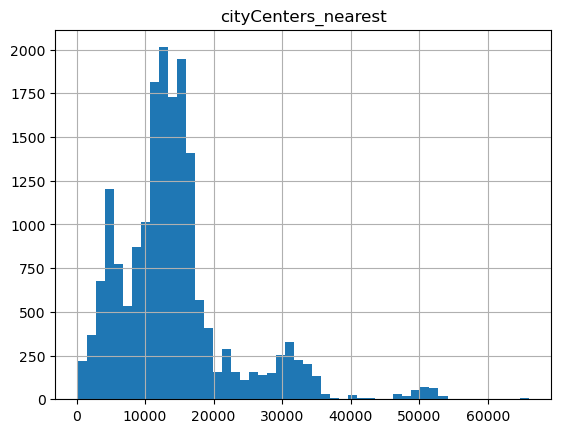

In [48]:
data.hist('cityCenters_nearest', bins=50);

In [49]:
data['cityCenters_nearest'].describe()

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Самым крупным городом в выборке является Санкт-Петербург. Удаленность самой окраины города от центра не должна превышать 25 км. Все, что выше этого, видимо, представляет собой что-то отличное от расстояния до центра города. Поэтому отсекаем аномалии и строим гистограмму:

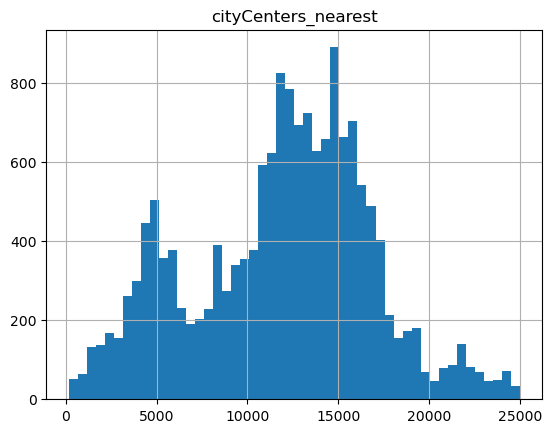

In [50]:
data.query('cityCenters_nearest <= 25000').hist('cityCenters_nearest', bins=50);

In [51]:
data.query('cityCenters_nearest <= 25000')['cityCenters_nearest'].describe()

count    16248.000000
mean     11856.578287
std       4960.182899
min        181.000000
25%       8460.000000
50%      12409.000000
75%      15195.250000
max      24972.000000
Name: cityCenters_nearest, dtype: float64

Большая часть кварти находится на расстоянии 10-15 км от центра города, что объясняется наличием спальных районов и застройкой новых кварталов на окраинах города.

**10. Расстояние до ближайшего парка**

Отобразим данные в виде гистограммы и числового описания выборки:

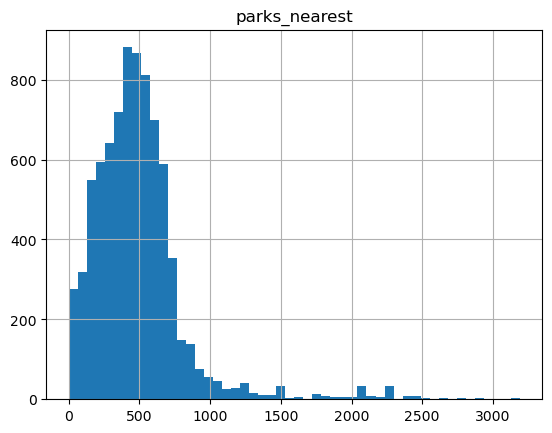

In [52]:
data.hist('parks_nearest', bins=50);

In [53]:
data['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Гистограмма показывает "хвост" данных, которыми можно пренебречь и отбросить - квартиры, располагающиеся дальше 1 км от ближайшего парка. Построим гистограмму без этого "хвоста":

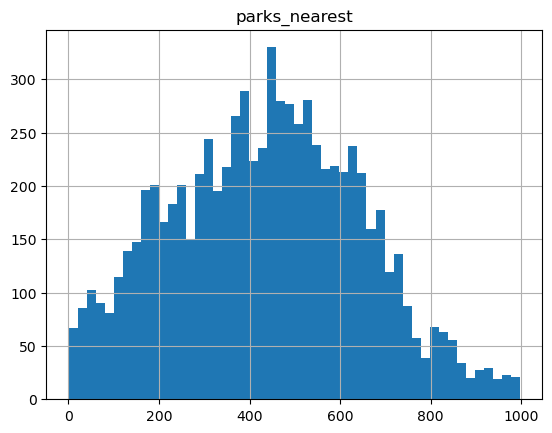

In [54]:
data.query('parks_nearest <= 1000').hist('parks_nearest', bins=50);

In [55]:
data.query('parks_nearest <= 1000')['parks_nearest'].describe()

count    7702.000000
mean      435.484420
std       209.639078
min         1.000000
25%       280.000000
50%       441.000000
75%       587.000000
max       997.000000
Name: parks_nearest, dtype: float64

Получили гистограмму, распределение которой похоже на нормальное. Среднестатистическая квартира в продаже располагается не дальше 440 метров от ближайшего парка.

По итогам проведенного анализа внесем изменения в текущий дасет и удалим из него аномальные значения для высоты потолков, стоимости квартиры, площади и количества комнат:

In [56]:
data = data.query('20 < = total_area <= 200 and 2 < = living_area <= 100 and 4 <= kitchen_area <= 30 and 400000 <= last_price <= 20000000 and 0 < rooms <= 5 and 2.5 <= ceiling_height_upd <= 3.5')

#### Анализ продаж квартир

Посмотрим, как быстро продавались квартиры - в датафрейме есть столбец, показывающий, сколько дней было размещено каждое объявление. Отобразим данные в виде гистограммы и числового описания выборки:

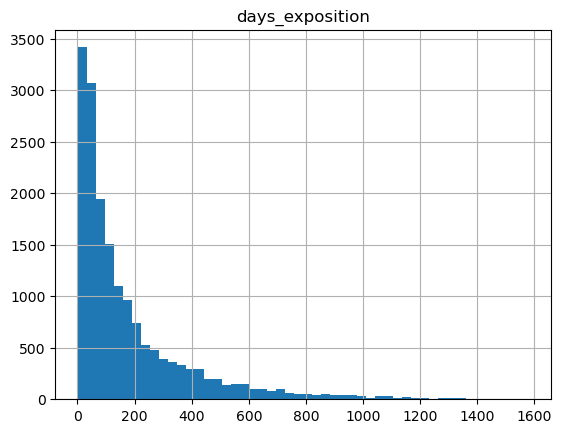

In [57]:
data.hist('days_exposition', bins=50);

In [58]:
data['days_exposition'].describe()

count    17213.000000
mean       180.976239
std        216.980370
min          1.000000
25%         44.000000
50%         99.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Как видно из представленных выше данных, в среднем продажа квартиры занимает 181 день. Учитывая длинный "хвост" объявлений, где продажа длилась более двух лет, с учетом небольшого числа таких объявлений, нужно ориентироваться на медианное значение продолжительности продажи - 95 дней. Необычно быстрыми можно считать продажи продолжительностью менее недели (если нет ошибки в данных, то это, возможно, выгодное предложение, низкая стоимость, хорошее расположение). Необычно долгими продажами являются те, продолжительность которых превышает один-два года (если нет ошибки в данных, то это, возможно, завышенная стоимость, неудачное расположение, некачественные фото в объявлении или их малое количество и т.д.)

#### Анализ факторов, влияющих на общую (полную) стоимость объекта

Факторы, влияющие на общую (полную) стоимость объекта, могут быть следующие:
- общая площадь
- жилая площадь
- площадь кухни
- количество комнат
- этаж, на котором расположена квартира (первый, последний, другой)
- даты размещения (день недели, месяц, год)

Добавим первые четыре фактора в отдельный датафрейм:

In [59]:
data_corr_1 = data[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms']]
data_corr_2 = data[['last_price', 'floor_type_text', 'day_exposition', 'month_exposition', 'year_exposition']]

Определим, какие из факторов больше всего влияют на общую (полную) стоимость объекта. Для этого построим матрицу корреляции Пирсона: 

In [60]:
data_corr_1.corr()

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.000000,0.755909,0.637979,0.553769,0.476362
total_area,0.755909,1.000000,0.921147,0.501937,0.794297
living_area,0.637979,0.921147,1.000000,0.246870,0.889972
kitchen_area,0.553769,0.501937,0.246870,1.000000,0.112190
rooms,0.476362,0.794297,0.889972,0.112190,1.000000


Также отобразим зависимости с помощью попарных диаграмм рассеяния:

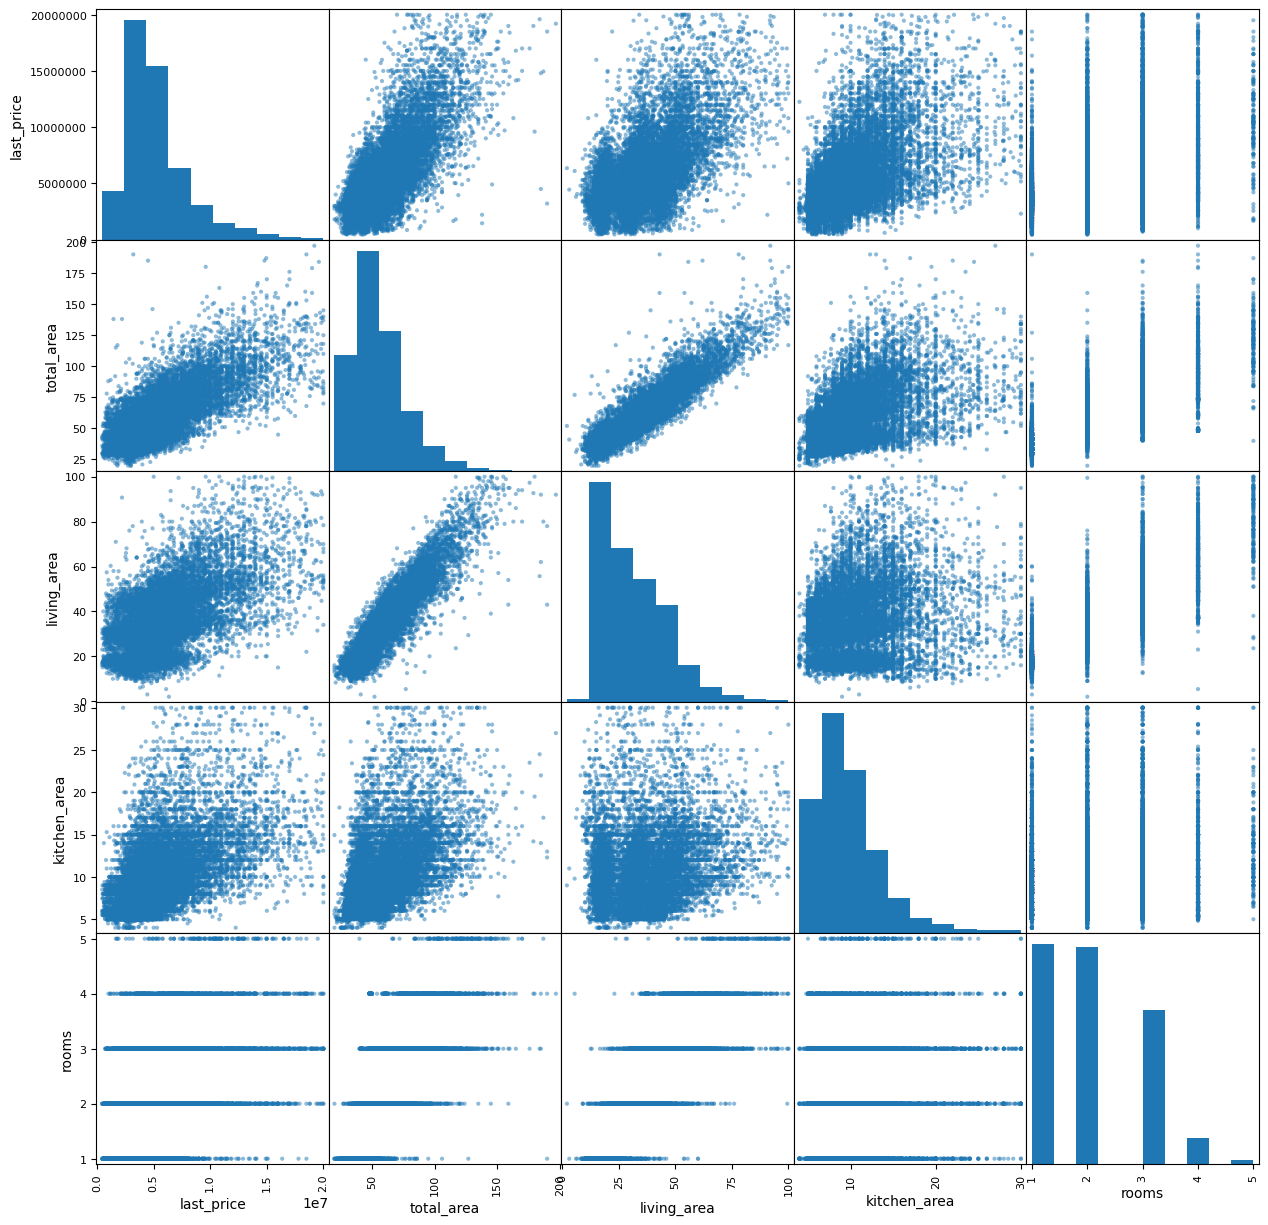

In [61]:
pd.plotting.scatter_matrix(data_corr_1, figsize=(15, 15));

На основании матрицы корреляции Пирсона и попарных диаграмм рассеяния можно сделать вывод о том, что стоимость объекта зависит от общей площади, жилой площади и площади кухни - чем они больше, тем выше стоимость. Количество комнат также влияет на стоимость квартиры, но в меньшей степени.

Рассчитывать корреляцию Пирсона для категории этажа, дня, месяца и года продажи не эффективно, т.к. цена в данном случае зависит от них не линейно (это категориальные переменные). Чтобы изучить зависимость для каждого из этих параметров построим столбчатую диаграмму и рассчитаем медианную стоимость объекта.

Произведем вычисления для этажа, на котором расположена квартира:

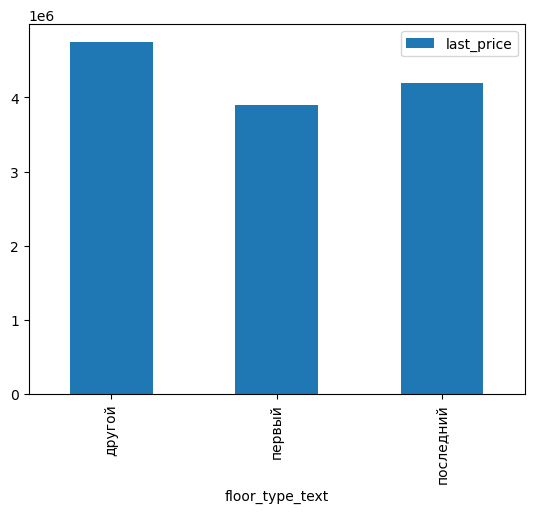

In [62]:
data_corr_2.pivot_table(index='floor_type_text', values='last_price', aggfunc='median').reset_index().plot(kind='bar', x='floor_type_text', y='last_price');

Согласно полученной диаграмме, стоимость объекта зависит от этажа - на первом этаже она ниже, чем на последнем, на этажах между первым и последним она самая высокая. 

Произведем вычисления для дня недели, когда было опубликовано объявление о продаже:

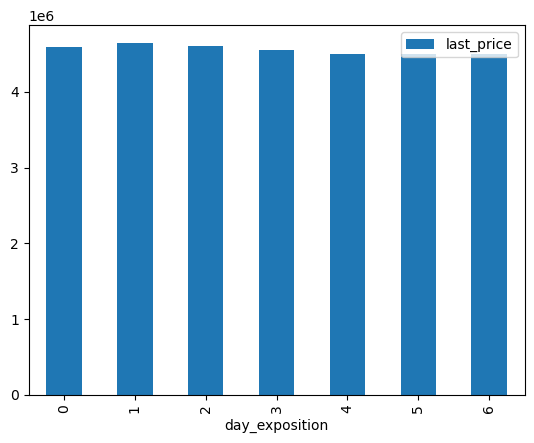

In [63]:
data_corr_2.pivot_table(index='day_exposition', values='last_price', aggfunc='median').reset_index().plot(kind='bar', x='day_exposition', y='last_price');

Согласно полученной диаграмме, стоимость объекта не зависит от дня недели, когда было опубликовано объявление о продаже - разница медианной стоимости по дням минимальная.

Произведем вычисления для месяца, когда было опубликовано объявление о продаже:

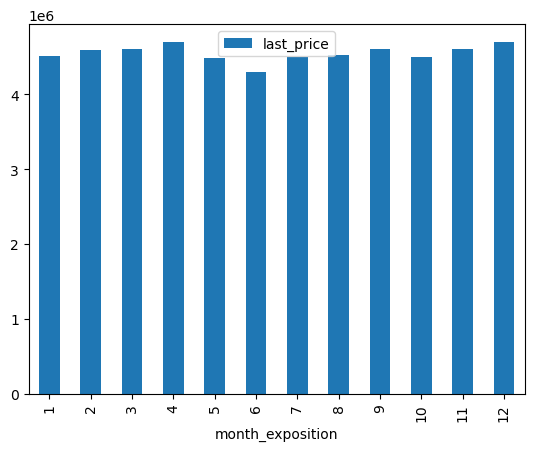

In [64]:
data_corr_2.pivot_table(index='month_exposition', values='last_price', aggfunc='median').reset_index().plot(kind='bar', x='month_exposition', y='last_price');

Согласно полученной диаграмме, стоимость объекта зависит от месяца, когда было опубликовано объявление о продаже - стоимость максимальна в апреле и декабре и минимальна в мае и июне.

Произведем вычисления для года, когда было опубликовано объявление о продаже:

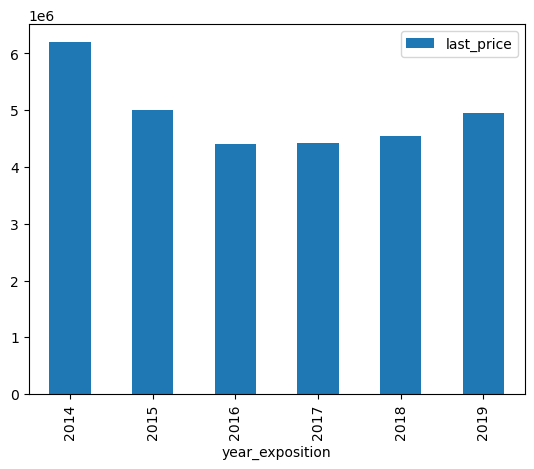

In [65]:
data_corr_2.pivot_table(index='year_exposition', values='last_price', aggfunc='median').reset_index().plot(kind='bar', x='year_exposition', y='last_price');

Согласно полученной диаграмме, стоимость объекта зависит от года, когда было опубликовано объявление о продаже - стоимость максимальна в 2014 году и минимальна в 2016 году.

#### Подсчет средней цены одного квадратного метра

Подсчитаем среднюю цену одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений. Для этого построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов:

In [66]:
data_mean_price = data.pivot_table(index='locality_name', values=['last_price', 'total_area'], aggfunc=['count', 'sum']).reset_index()
data_mean_price.columns = ['locality_name', 'count', 'count_2', 'sum_price', 'sum_total_area']
data_mean_price['mean_area_price'] = (data_mean_price['sum_price'] / data_mean_price['sum_total_area']).round(2)
data_mean_price = data_mean_price[['locality_name', 'count', 'mean_area_price']]
data_mean_price_top_10 = data_mean_price.sort_values(by='count', ascending=False).head(10)
data_mean_price_top_10

,locality_name,count,mean_area_price
50,Санкт-Петербург,13006,108155.55
31,Мурино,456,83719.16
254,поселок Шушары,389,76800.20
23,Кудрово,375,94814.84
5,Всеволожск,353,67249.23
19,Колпино,320,73894.71
45,Пушкин,317,103417.34
207,поселок Парголово,287,88502.87
9,Гатчина,287,68737.58
38,Петергоф,186,83788.46


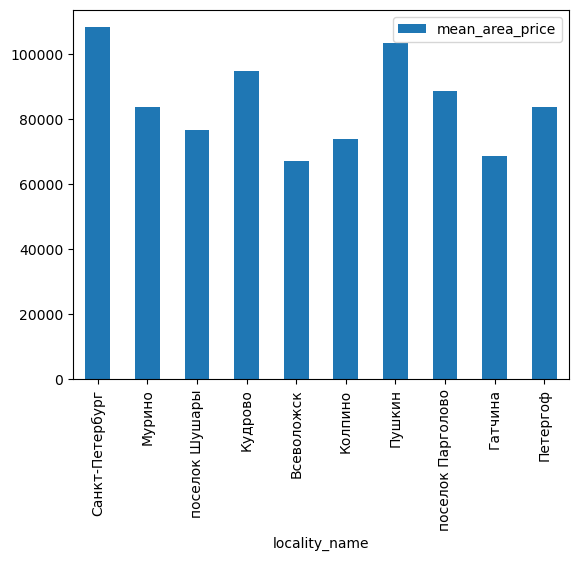

In [67]:
data_mean_price_top_10.plot(kind='bar', x='locality_name', y='mean_area_price');

Таким образом, наибольшее количество объявлений о продаже квартир включает в себя Санкт-Петербург и его пригороды. При этом средняя цена квадратного метра в Топ-10 городов варьируется от 67 тыс. руб. до 108 тыс. руб.

Выделим населенные пункты с самой высокой стоимостью квадратного метра:

In [68]:
data_mean_price.sort_values(by='mean_area_price', ascending=False).head(5)

,locality_name,count,mean_area_price
50,Санкт-Петербург,13006,108155.55
45,Пушкин,317,103417.34
11,Зеленогорск,22,100563.28
53,Сестрорецк,162,100019.19
23,Кудрово,375,94814.84


Самая высокая стоимость квадратного метра ожидаемо оказалась в Санкт-Петербурге и его близлежащих пригородах.

Выделим населенные пункты с самой низкой стоимостью квадратного метра:

In [69]:
data_mean_price.sort_values(by='mean_area_price', ascending=True).head(5)

,locality_name,count,mean_area_price
138,деревня Старополье,1,10465.12
80,деревня Выскатка,2,12446.81
155,деревня Ям-Тесово,1,12500.00
233,поселок Совхозный,1,12555.56
260,поселок городского типа Ефимовский,1,12686.57


Самая низкая стоимость квадратного метра оказалась в деревнях, максимально удаленных от Санкт-Петербурга.

#### Зависимость стоимости объектов от расстояния до центра города

Выделим квартиры в Санкт-Петербурге и вычислим их среднюю стоимость на разном удалении от центра:

In [70]:
spb_data = data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', columns='locality_name', values='last_price', aggfunc='mean').reset_index()
spb_data.columns = ['cityCenters_nearest_km', 'mean_price']
spb_data

,cityCenters_nearest_km,mean_price
0,0.0,9.027143e+06
1,1.0,9.716870e+06
2,2.0,9.471500e+06
3,3.0,8.582996e+06
4,4.0,8.880071e+06
5,5.0,8.920970e+06
6,6.0,8.186470e+06
7,7.0,7.779224e+06
8,8.0,7.741483e+06
9,9.0,6.420421e+06


Построим график изменения средней цены для каждого километра от центра Санкт-Петербурга:

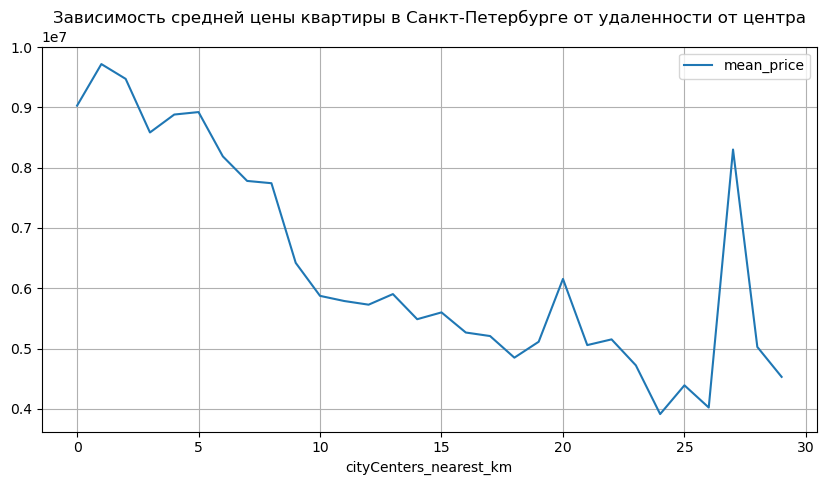

In [71]:
spb_data.plot(x='cityCenters_nearest_km', y='mean_price', grid=True, figsize=(10, 5), title='Зависимость средней цены квартиры в Санкт-Петербурге от удаленности от центра');

График показывает, как изменяется стоимость объектов в зависимости от расстояния до центра города - чем дальше от центра, тем ниже стоимость. На графике также видны всплески роста квартир, несмотря на удаленность от центра - такие аномалии также требуют анализа данных и их удалению, если они не могут быть логически объяснены.

### Общий вывод

Были проанализированы данные сервиса Яндекс Недвижимость - архив объявлений о продаже квартир в Санкт-Петербурге и соседних населенных пунктах за несколько лет.

Предобработка данных включала в себя:
1. Заполнение пропусков там, где была возможно это сделать: количество балконов, этажность зданий, флаг апартаментов, число парков и водоемов в радиусе 3 км
2. Изменение типов данных в столбцах
3. Удаление неявных дубликатов в названиях населенных пунктов

С целью улучшения качества исходных данных проблемы с выгружаемыми данными, как правило, необходимо решать на уровне сбора данных, а не их обработки. Нельзя давать возможность добавлять в базу стандартизированные данные в произвольной форме, в частности, названия населенных пунктов. Для этого должен быть закрытый перечень для выбора.

Для проведения исследования в датафрейм были добавлены новые столбцы:
1. Цена одного квадратного метра
2. День недели публикации объявления
3. Месяц публикации объявления
4. Год публикации объявления
5. Тип этажа квартиры
6. Расстояние до центра города в километрах

Был проведен анализ данных, представленных в датафрейме:
1. Общая площадь
2. Жилая площадь
3. Площадь кухни
4. Цена объекта
5. Количество комнат
6. Высота потолков
7. Тип этажа квартиры
8. Общее количество этажей в доме
9. Расстояние до центра города в метрах
10. Расстояние до ближайшего парка

На основе анализа можно сделать вывод о том, что данные содержат аномалии (минимальные и максимальные значения), которые могут искажать сущность данных, поэтому для последующего анализа необходимо прибегать к постороению гистограмм, оценивать минимальные и максимальные значения выборки, среднее и медиану, а также прочие статистические показатели.

Проведенный анализ продаж квартир показал, что для определения средней продолжительности продажи квартиры необходимо ориентроваться на медианное значение выборки, т.к. в данных имеются как необычно быстрые продажи (несколько дней), так и необычно долгие продажи (несколько лет).

В исследовании на основании матрицы корреляции Пирсона и попарных диаграмм рассеяния были определены факторы, влияющие на общую (полную) стоимость объекта. Такими факторами оказались общая площадь, жилая площадь, площадь кухни и количество комнат. Зависимость стоимости объекта от остальных качественных факторов (этаж, на котором расположена квартира и дата размещения объявления о продаже) была определена с помощью столбчатой диаграммы и рассчета медианы. было выявлено, что день размещения объявления о продаже не влияет на стоимость объекта.

В рамках исследования был произведен подсчет средней цены одного квадратного метра в 10 населенных пунктах с наибольшим числом объявлений. Было выявлено, что наибольшее количество объявлений о продаже квартир включает в себя Санкт-Петербург и его пригороды и средняя цена квадратного метра в этих городах может отличаться вдвое - от 67 тыс. руб. до 108 тыс. руб. Самая высокая стоимость квадратного метра оказалась в Санкт-Петербурге и его близлежащих пригородах, в то время как самая низкая стоимость квадратного метра оказалась в населенных пунктах, максимально удаленных от Санкт-Петербурга.

На примере Санкт-Петербурга с помощью графика была выявлена зависимость стоимости объектов от расстояния до центра города - чем дальше от центра, тем ниже стоимость.